In [27]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():  
    dev = torch.device("cuda:0")
else:
    dev = torch.device("cpu")
dev = torch.device("cpu")
print(f"Using {dev}")

Using cpu


MAX LENGTH:217


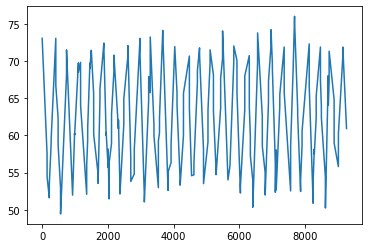

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180


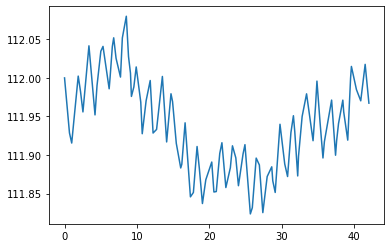

In [28]:
# ---- data loading and pre-processing ---- #

import polar_pla as pla
import numpy as np
import torch
from torch.autograd import Variable

# read in time series into temporary list
temp = []
f = open('DataSets/CTtemp.csv', 'r')
for line in f:
    temp.append(float(line))

# run bottom up piecewise linear approximation on that list and store processed values
data = pla.bottom_up_pla(temp,1000)
pla.display_trends(data, 112)
#print(data)
# set the sequence length (the number of trends we look at to predict the next) and the train to test ratio
seq_length = 3
train_proportion = 0.5

# segment the data into input output pairs that we will use to train the model
def sliding_window(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length*2, 2):
        print(i)
        temp = data[i:(i+seq_length*2)]
        new = []
        for x in range(0,len(temp),2):
            new.append([temp[x],temp[x+1]])
        #print(new)
        inputs.append(new)
        #inputs.append(data[i:(i+seq_length*2)]) # the next n are the input
        #inputs.append([temp[::2],temp[1::2]])
        outputs.append(data[i+seq_length*2+1:i+seq_length*2+2]) # and the one after that is the output
    return Variable(torch.Tensor(np.array(inputs)).to(dev)), Variable(torch.Tensor(np.array(outputs)).to(dev))
# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size)

testing_data_input = torch.narrow(total_data_input, 0, train_size, len(total_data_input) - train_size)
testing_data_output = torch.narrow(total_data_output, 0, train_size, len(total_data_input) - train_size)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)
trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [29]:
from torch import nn
from tcn import TemporalConvNet
import torch.nn.functional as F

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])

#net = TCN(seq_length,2,[2,64,64])#TCN(seq_length*2, 1, [2]*32)
net = TCN(seq_length,1, [32]*4, 2, 0.01)
net = net.to(dev)
print(net)

TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(3, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.01, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.01, inplace=False)
        (net): Sequential(
          (0): Conv1d(3, 32, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.01, inplace=False)
          (4): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.01, inplace=False)
        )
        (downsample): Conv1d(3, 32, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,)

Epoch: 0/2000, loss: 0.13825708627700806
Epoch: 200/2000, loss: 0.009059843607246876
Epoch: 400/2000, loss: 0.0011594126699492335
Epoch: 600/2000, loss: 0.0010845288634300232
Epoch: 800/2000, loss: 0.005621257703751326
Epoch: 1000/2000, loss: 0.0020789182744920254
Epoch: 1200/2000, loss: 0.0011682502226904035
Epoch: 1400/2000, loss: 0.0029677501879632473
Epoch: 1600/2000, loss: 0.000595075252931565
Epoch: 1800/2000, loss: 0.0009099441231228411
Epoch: 2000/2000, loss: 0.001044624368660152


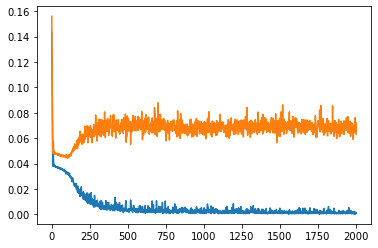

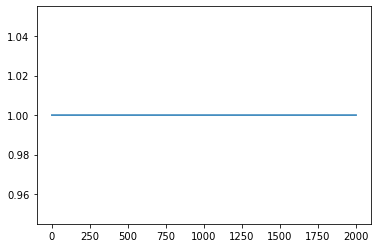

Lowest validation loss: 0.044429246336221695 at epoch 102


In [30]:
# training

epochs = 2000

import torch.optim as optim
train_loss = []
validation_loss = []
net.train()
epoch_total_trainloss = 0 # the total loss for each epoch, used for plotting
min_val_loss_epoch = 0 # the epoch with the lowest validation loss
min_val_loss = 1000000 # the lowest validation loss
optimizer = optim.Adam(net.parameters(), lr=0.001)
train_direction_accuracy = []
validation_direction_accuracy = []
for epoch in range(epochs+1):

    # this is the validation part, ideally we wouldn't do this every epoch, but it's easy and
    # gives good insight into when the model overfits
    for data in testset:
        torch.cuda.synchronize()
        features, labels = data  # split the batches up into their features and labels
        net.zero_grad()
        #print(features.shape)
        output = net(features)  # get a prediction from the model
        #print(output.shape)
        #print(labels.shape)
        output = output
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        epoch_total_trainloss += loss.item()/len(testset)
    
    if epoch_total_trainloss < min_val_loss:
        min_val_loss = epoch_total_trainloss
        min_val_loss_epoch = epoch

    validation_loss.append(epoch_total_trainloss) # we'll need to plot validation loss too
    epoch_total_trainloss = 0 # reset this for the validation epoch'''
    for data in trainset:  # for each batch
        torch.cuda.synchronize()
        features, labels = data  # split the batches up into their features and labels
        net.zero_grad()
        output = net(features)  # get a prediction from the model
        output = output
        #print(output.shape)
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        loss.backward()  # backpropogate the loss
        optimizer.step()  # optimize weights
        epoch_total_trainloss += loss.item()/len(trainset)  # sum the losses of this epoch
    
    train_loss.append(epoch_total_trainloss) # add this epoch's loss in order to plot it later
    epoch_total_trainloss = 0 # reset this for the validation epoch

    # now we'll calculate the direction accuracy for the training and validation sets
    correct=0
    for data in testset:
        torch.cuda.synchronize()
        inputs, labels = data
        output = net(inputs)
        for i in range(len(output)):
            pred = output[i]
            actual = labels[i]
            if pred < 0 and actual < 0 or pred > 0 and actual > 0:
                correct += 1
            #print(output[0],labels[0])
    validation_direction_accuracy.append(correct/len(test))

    if epoch %(epochs/10) == 0: print(f"Epoch: {epoch}/{epochs}, loss: {loss.item()}")

import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()
plt.plot(validation_direction_accuracy)
plt.show()
print(f"Lowest validation loss: {min_val_loss} at epoch {min_val_loss_epoch}")

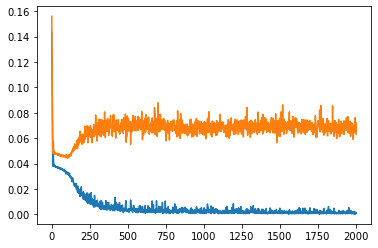

Directional Accuracy: 100.0


In [32]:
# test
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()

correct=0
output_file = open("length.txt", "w")
for data in trainset:
    inputs, labels = data
    output = net(inputs)
    for i in range(len(output)):
        pred = output[i]
        output_file.write(str(pred.item())+"\n")

for data in testset:
    inputs, labels = data
    output = net(inputs)
    for i in range(len(output)):
        pred = output[i]
        actual = labels[i]
        if pred < 0 and actual < 0 or pred > 0 and actual > 0:
            correct += 1
        output_file.write(str(pred.item())+"\n")
print(f'Directional Accuracy: {correct*100/len(test)}')